# Estimate the diameter (mm) from the amodal and visible masks, using extrapolation and filtering techniques

In [1]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
from numpy.linalg import inv
import os
import cv2
import random
import tifffile
from pyexcel_ods import get_data
import csv
import json
from tqdm import tqdm
import time
import seaborn as sns
import pandas as pd

# import some miscellaneous libraries
from utils import visualize
from utils import statistics

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog,MetadataCatalog
from detectron2.engine import DefaultTrainer
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10,10

def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    plt.show()

## Register the amodal dataset 

In [2]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("broccoli_amodal_test", {}, "datasets/train_val_test_files/mrcnn/test/annotations.json", "datasets/train_val_test_files/mrcnn/test")

In [3]:
broccoli_amodal_test_metadata = MetadataCatalog.get("broccoli_amodal_test")
print(broccoli_amodal_test_metadata)

Metadata(evaluator_type='coco', image_root='datasets/train_val_test_files/mrcnn/test', json_file='datasets/train_val_test_files/mrcnn/test/annotations.json', name='broccoli_amodal_test')


In [4]:
dataset_dicts_test = DatasetCatalog.get("broccoli_amodal_test")

[10/24 19:53:29 d2.data.datasets.coco]: Loaded 487 images in COCO format from datasets/train_val_test_files/mrcnn/test/annotations.json


## Initialize the image inference

In [5]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_orcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (broccoli)

cfg.OUTPUT_DIR = "weights/20201010_broccoli_amodal_visible"
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0007999.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.01
cfg.DATASETS.TEST = ("broccoli_amodal_test",)

predictor = DefaultPredictor(cfg)

## Circle fit on the contour of the amodal mask

In [6]:
## ransac code extracted from: https://github.com/SeongHyunBae/RANSAC-circle-python
class RANSAC:
    def __init__(self, x_data, y_data, n):
        self.x_data = x_data
        self.y_data = y_data
        self.n = n
        self.d_min = 99999
        self.best_model = None

    def random_sampling(self):
        sample = []
        save_ran = []
        count = 0

        # get three points from data
        while True:
            ran = np.random.randint(len(self.x_data))

            if ran not in save_ran:
                sample.append((self.x_data[ran], self.y_data[ran]))
                save_ran.append(ran)
                count += 1

                if count == 3:
                    break

        return sample

    def make_model(self, sample):
        # calculate A, B, C value from three points by using matrix
    
        pt1 = sample[0]
        pt2 = sample[1]
        pt3 = sample[2]

        A = np.array([[pt2[0] - pt1[0], pt2[1] - pt1[1]], [pt3[0] - pt2[0], pt3[1] - pt2[1]]]) 
        B = np.array([[pt2[0]**2 - pt1[0]**2 + pt2[1]**2 - pt1[1]**2], [pt3[0]**2 - pt2[0]**2 + pt3[1]**2 - pt2[1]**2]])		
        inv_A = inv(A)

        c_x, c_y = np.dot(inv_A, B) / 2
        c_x, c_y = c_x[0], c_y[0]
        r = np.sqrt((c_x - pt1[0])**2 + (c_y - pt1[1])**2)

        return c_x, c_y, r

    def eval_model(self, model):
        d = 0
        c_x, c_y, r = model

        for i in range(len(self.x_data)):
            dis = np.sqrt((self.x_data[i]-c_x)**2 + (self.y_data[i]-c_y)**2)

            if dis >= r:
                d += dis - r
            else:
                d += r - dis

        return d

    def execute_ransac(self):
        # find best model
        for i in range(self.n):
            model = self.make_model(self.random_sampling())
            d_temp = self.eval_model(model)

            if self.d_min > d_temp:
                self.best_model = model
                self.d_min = d_temp


def circle_fit(masks, method="ransac"):
    masks = masks.astype(np.uint8)

    if masks.any():
        maskstransposed = masks.transpose(1,2,0) # transform the mask in the same format as the input image array (h,w,num_dets)
        cXs = np.zeros(maskstransposed.shape[-1],dtype=np.uint16)
        cYs = np.zeros(maskstransposed.shape[-1],dtype=np.uint16)
        diameters = np.zeros(maskstransposed.shape[-1],dtype=np.float32)

        for i in range (maskstransposed.shape[-1]):
            masksel = maskstransposed[:,:,i] # select the individual masks

            if method == "min_enclosing_circle":                   
                contours, hierarchy = cv2.findContours((masksel*255).astype(np.uint8),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
                cnt = np.concatenate(contours)
                (x,y),radius = cv2.minEnclosingCircle(cnt)
                cXs[i] = int(x)
                cYs[i] = int(y)
                diameters[i] = radius*2

                
            if method == "ransac":
                contours, hierarchy = cv2.findContours((masksel*255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                cnt = np.concatenate(contours)

                # convex hull
                uni_hull = []
                hull = cv2.convexHull(cnt)
                uni_hull.append(hull)

                # ransac circle fit
                hull_points = uni_hull[0].reshape((uni_hull[0].shape[0],2))
                x_data = []
                y_data = []

                for p in range(len(hull_points)):
                    point = hull_points[p]
                    x_data.append(point[0])
                    y_data.append(point[1])

                ransac = RANSAC(x_data, y_data, 50)
                ransac.execute_ransac()
                a, b, r = ransac.best_model[0], ransac.best_model[1], ransac.best_model[2]

                cXs[i] = int(a)
                cYs[i] = int(b)
                diameters[i] = r*2


    else:
        cXs = 0
        cYs = 0
        diameters = 0

    return cXs, cYs, diameters

## Histogram filtering on the depth channel of the XYZ image

In [7]:
def histogram_filtering(xyzimg, masks, max_depth_range_broc=100, max_depth_contribution=0.04):
    masks = masks.astype(np.uint8)
    z = np.expand_dims(xyzimg[:,:,-1], axis=2)

    if masks.any():
        md, mh, mw = masks.shape
        masks_final = np.zeros((md,mh,mw),dtype=np.uint8)
        maskstransposed = masks.transpose(1,2,0) 
        zts = np.zeros(maskstransposed.shape[-1])
        zes = np.zeros(maskstransposed.shape[-1])

        for i in range (maskstransposed.shape[-1]):
            masksel = maskstransposed[:,:,i]                  
            masksel_bool = masksel.astype(np.bool)

            z_mask = z[masksel_bool]
            z_mask_filtered = z_mask[z_mask != 0]

            if z_mask_filtered.size > 1: 
                z_mask_filtered_range = np.max(z_mask_filtered)-np.min(z_mask_filtered)

                if (z_mask_filtered_range > max_depth_range_broc):
                    hist, bin_edges = np.histogram(z_mask_filtered, density=False)
                    hist_peak = np.argmax(hist)
                    lb = bin_edges[hist_peak]
                    ub = bin_edges[hist_peak+1]

                    bc = np.bincount(np.absolute(z_mask_filtered.astype(np.int64)))
                    peak_id = np.argmax(bc)

                    if peak_id > int(lb) and peak_id < int(ub):
                        peak_id = peak_id
                    else:
                        bc_clip = bc[int(lb):int(ub)]
                        peak_id = int(lb) + np.argmax(bc_clip)

                    pixel_counts = np.zeros((10), dtype=np.int64)

                    for j in range(10):
                        lower_bound = peak_id-(max_depth_range_broc - (j * 10))
                        upper_bound = lower_bound + max_depth_range_broc
                        z_final = z_mask_filtered[np.where(np.logical_and(z_mask_filtered >= lower_bound, z_mask_filtered <= upper_bound))]
                        pixel_counts[j] = z_final.size

                    pix_id = np.argmax(pixel_counts)
                    lower_bound = peak_id-(max_depth_range_broc - (pix_id * 10))
                    upper_bound = lower_bound + max_depth_range_broc
                    z_final = z_mask_filtered[np.where(np.logical_and(z_mask_filtered >= lower_bound, z_mask_filtered <= upper_bound))]

                    hist_f, bin_edges_f = np.histogram(z_final, density=False)
                    norm1 = hist_f / np.sum(hist_f)

                else:
                    hist_f, bin_edges_f = np.histogram(z_mask_filtered, density=False)
                    norm1 = hist_f / np.sum(hist_f)

                sel1 = bin_edges_f[np.where(norm1 >= max_depth_contribution)]
                sel2 = bin_edges_f[np.where(norm1 >= max_depth_contribution)[0]+1]
                edges = np.concatenate((sel1,sel2), axis=0)
                final_bins = np.unique(edges)

                z_top = np.min(final_bins)
                z_edge = np.max(final_bins)

                zts[i] = z_top
                zes[i] = z_edge
            else:
                zts[i] = 0
                zes[i] = 0

    else:
        zts = 0
        zes = 0

    return z, zts, zes

## Extract the pixel-to-mm ratio

In [8]:
def pixel_to_mm(xyzimg, boxes, masks, zes):
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]

    if masks.any():
        maskstransposed = masks.transpose(1,2,0)
        pixel_to_mm_ratios = np.zeros(maskstransposed.shape[-1],dtype=np.float32)  

        for i in range (maskstransposed.shape[-1]):
            masksel = np.expand_dims(maskstransposed[:,:,i],axis=2).astype(np.uint8) # select the individual masks
            bbox = boxes[i].astype(np.uint16)
            masksel = masksel[bbox[1]:bbox[3],bbox[0]:bbox[2]] # crop the mask to the boxing box to reduce memory load

            xyz_mask = xyzimg[bbox[1]:bbox[3],bbox[0]:bbox[2]]
            xyz_mask = np.multiply(xyz_mask,masksel)
            z = xyz_mask[:,:,2] 

            ze = zes[i]
            zflat = z.flatten()

            if ze > 0:
                z_edge = find_nearest(zflat, ze)
                xyz_edge = np.where(xyz_mask == z_edge)
                attempts = 0

                while len(xyz_edge[0]) < 2:
                    z_edge_prev = z_edge
                    zflat = zflat[zflat != z_edge_prev]
                    z_edge = find_nearest(zflat, z_edge_prev)
                    xyz_edge = np.where(xyz_mask == z_edge)
                    attempts = attempts+1

                    if int(attempts) > 10:
                        zflat = z.flatten()
                        z_edge = find_nearest(zflat, ze)
                        xyz_edge = np.where(xyz_mask == z_edge)
                        break

                x1_edge = xyz_edge[0][0]
                y1_edge = xyz_edge[1][0]

                pixel1 = np.asarray((x1_edge, y1_edge))
                xyz1 = xyz_mask[x1_edge, y1_edge,:]

                if len(xyz_edge[0]) >= 2:
                    x2_edge = xyz_edge[0][1]
                    y2_edge = xyz_edge[1][1]

                    pixel2 = np.asarray((x2_edge, y2_edge))
                    xyz2 = xyz_mask[x2_edge, y2_edge, :]
                else:
                    z_edge_new = find_nearest(zflat[zflat != z_edge], z_edge)
                    xyz_edge_new = np.where(xyz_mask == z_edge_new)

                    x2_edge = xyz_edge_new[0][0]
                    y2_edge = xyz_edge_new[1][0]

                    pixel2 = np.asarray((x2_edge, y2_edge))
                    xyz2 = xyz_mask[x2_edge, y2_edge, :]
                    xyz2[2] = z_edge

                dist_pixel = np.linalg.norm(pixel1-pixel2)
                dist_mm = np.linalg.norm(xyz1-xyz2)
                pixel_to_mm_ratios[i] = np.divide(dist_mm, dist_pixel)

    else:
        pixel_to_mm_ratios=0

    return pixel_to_mm_ratios

## Estimate the real-world diameter (mm) from the amodal and visible masks, using extrapolation and filtering techniques

In [9]:
# User input needed (directory, file locations, etc):
analysis_name = "orcnn_with_filtering"
xyzimgdir = "./datasets/train_val_test_files/regression/test"
gtfile = "./datasets/train_val_test_files/groundtruth_measurements_broccoli.ods" ## comment out if there is no ground truth file (also restart the kernel)

100%|██████████| 487/487 [01:33<00:00,  5.23it/s]


20200713_114109952370_plant1029_rgb_trigger002.png


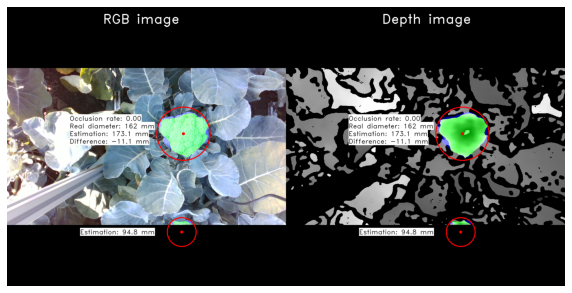

20200819_093608886875_plant1135_rgb_trigger001.png


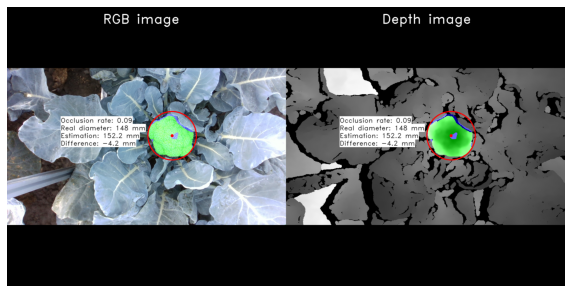

182_Untrimmed_Frame_6_164_rgb.png


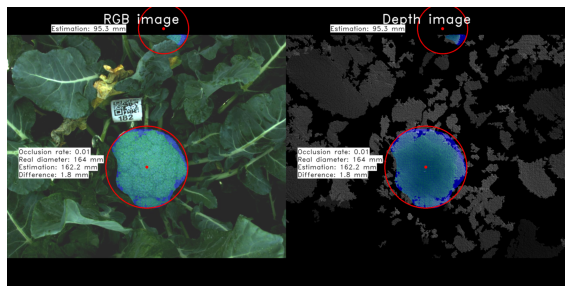

3556_Untrimmed_Frame_5_150_rgb.png


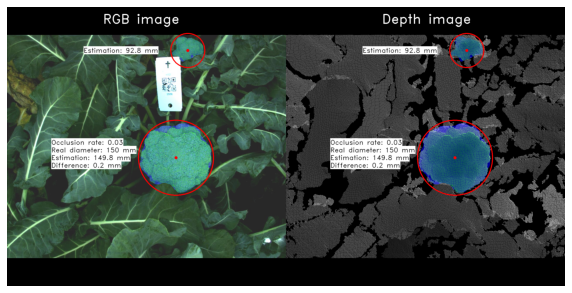

3551_Untrimmed_Frame_4_177_rgb.png


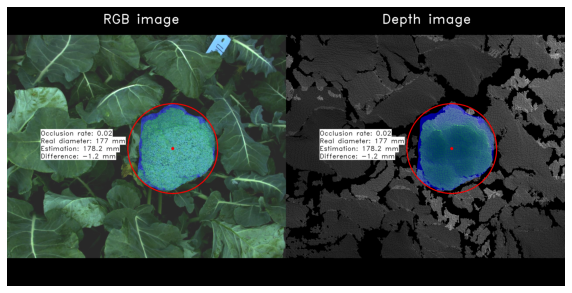

3563_Untrimmed_Frame_3_105_rgb.png


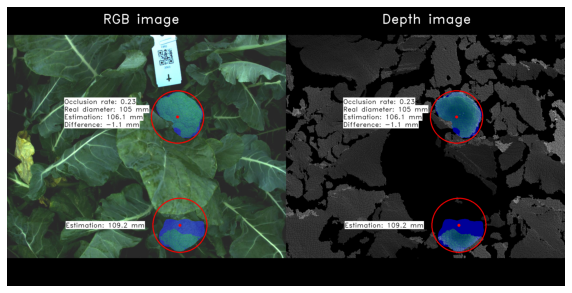

20200713_111033226018_plant1019_rgb_trigger008.png


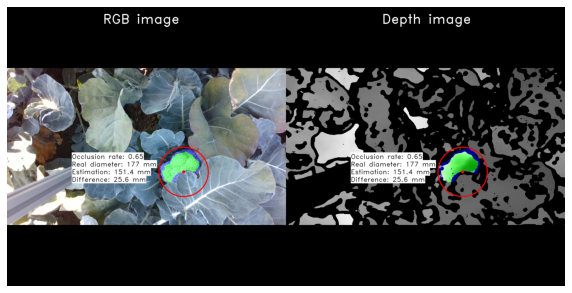

20200713_153940416415_plant1090_rgb_trigger005.png


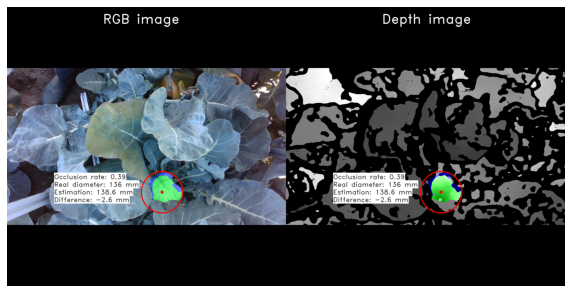

20200819_144053443125_plant1190_rgb_trigger001.png


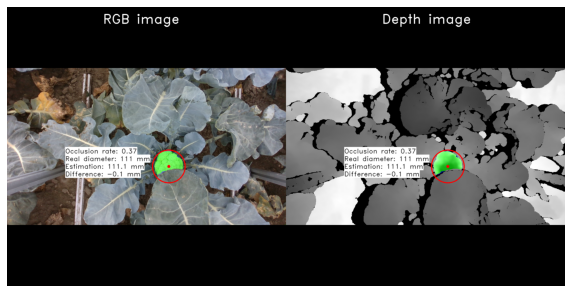

20200819_171101975009_plant1233_rgb_trigger011.png


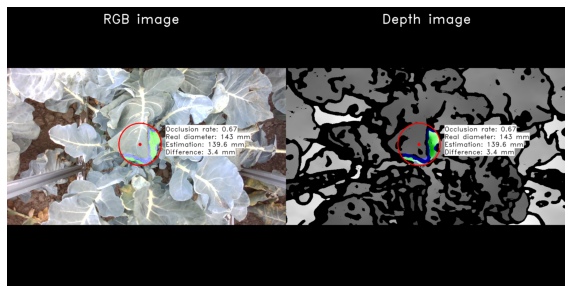

In [10]:
writedir = os.path.join("./results", analysis_name)

if not os.path.exists(writedir):
    os.makedirs(writedir)

try:
    gt = get_data(gtfile)
    gt_file_present = True
except:
    gt_file_present = False

csv_name = 'broccoli_diameter_' + analysis_name + '.csv'
with open(os.path.join(writedir, csv_name), 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    csvwriter.writerow(['image_id', 'amodal IoU', 'real-world diameter (mm)', 'diameter estimation (mm)', 'difference in diameter (mm)', 'occlusion rate', 'image analysis time (s)'])

ious = []
diffs = []
vprs = []
gtsizes = []
inference_times = []

ids_visualize = np.random.choice(np.arange(len(dataset_dicts_test)), 10)
random_images = []
random_imagenames = []

for i in tqdm(range(len(dataset_dicts_test))):
    # Load the RGB image
    imgname = dataset_dicts_test[i]["file_name"]
    basename = os.path.basename(imgname)
    img = cv2.imread(imgname)
    
    
    # Load the XYZ image
    xyzimgname = basename.replace("rgb", "xyz")
    xyzimgname = xyzimgname.replace(".png", ".tiff")
    xyzimg = tifffile.imread(os.path.join(xyzimgdir, xyzimgname))
    
    
    # Do the image inference and extract the outputs from Mask R-CNN
    start_time = time.time()
    outputs = predictor(img)
    instances = outputs["instances"].to("cpu")
    classes = instances.pred_classes.numpy()
    scores = instances.scores.numpy()
    boxes = instances.pred_boxes.tensor.numpy()
    

    # Procedure to check whether we are dealing with ORCNN or MRCNN
    if "pred_visible_masks" in instances._fields:
        amodal_masks = instances.pred_masks.numpy()
        visible_masks = instances.pred_visible_masks.numpy()        
    else:
        visible_masks = instances.pred_masks.numpy()
        
        
    # Procedure to load the annotations (to calculate the amodal IoU)
    d = dataset_dicts_test[i]
    classes_annot = []
    amodal_masks_poly = []
    for k in range(len(d["annotations"])):
        classes_annot.append(d["annotations"][0]['category_id'])
        amodal_masks_poly.append(d["annotations"][k]['segmentation'])


    # Circle fit
    if "pred_visible_masks" in instances._fields:
        cXs, cYs, diameters_pixel = circle_fit(amodal_masks, "ransac")
    else:
        cXs, cYs, diameters_pixel = circle_fit(visible_masks, "ransac")
        
        
    # Calculate the amodal IoU    
    amodal_masks_annot = visualize.make_mask_img(amodal_masks_poly, d['height'], d['width'], "polylines")
    amodal_circle = visualize.make_mask_img([cXs,cYs,diameters_pixel], d['height'], d['width'], "circle")
    iou_amodal = statistics.calculate_iou(amodal_masks_annot, amodal_circle, np.array(classes_annot), classes)
    max_iou_amodal = np.amax(iou_amodal, axis=0)
        

    # Do the histogram filtering on the Z-image (depth image)
    zimg, zts, zes = histogram_filtering(xyzimg, visible_masks, 100, 0.04)
    pixel_to_mm_ratios = pixel_to_mm(xyzimg, boxes, visible_masks, zes)
    

    # Get the real-world diameters (mm)
    diameters_mm = np.multiply(diameters_pixel, pixel_to_mm_ratios)
    end_time = time.time()
    elapsed_time = end_time-start_time
    inference_times.append(elapsed_time)
    
    
    # Get the ground truth data
    real_diameter = 0
    visible_pixel_ratio = 0
    gt_data_present = False
    
    if gt_file_present:
        for k in range(1, len(gt['groundtruth_measurements_broccoli'])):
            gt_data = gt['groundtruth_measurements_broccoli'][k]
            if gt_data:
                if gt_data[0] == basename:
                    gt_data_present = True
                    plant_id = gt_data[1]
                    real_diameter = gt_data[2]
                    x_center_gt = gt_data[3]
                    y_center_gt = gt_data[4]
                    visible_pixel_ratio = float(gt_data[5])
                    occlusion_rate = float(1-visible_pixel_ratio)
                    coordinates_broccoli_gt = (x_center_gt, y_center_gt)
                

    # Find the broccoli head that belongs to the ground truth data
    distances = []
    if np.logical_and(boxes.size > 0, gt_data_present):
        for h in range(len(boxes)):
            box = boxes[h]
            x_center = box[0] + ((box[2] - box[0]) / 2)
            y_center = box[1] + ((box[3] - box[1]) / 2)
            distances.append(np.linalg.norm(np.asarray(coordinates_broccoli_gt) - np.asarray((x_center, y_center))))

        idx = np.asarray(distances).argmin()
        diameter = diameters_mm[idx]
        amodal_IoU = max_iou_amodal[idx]
    else:
        idx = []
        diameter = np.nan
        amodal_IoU = np.nan
        

    # Store the randomly selected images in an array
    if i in ids_visualize:
        img_output, zimg_output = visualize.visualize_results(img, zimg, boxes, visible_masks, np.array([]), zts, zes, cXs, cYs, diameters_pixel, diameters_mm, idx, str(real_diameter), occlusion_rate)
        img_mosaic = np.hstack((img_output, zimg_output))
    
        random_imagenames.append(basename)
        random_images.append(img_mosaic)
    

    # Store the results
    if gt_data_present:
        with open(os.path.join(writedir, csv_name), 'a', newline='') as csvfile:
            csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
            csvwriter.writerow([xyzimgname, round(amodal_IoU, 3), round(real_diameter, 1), round(diameter, 1), round(np.subtract(real_diameter, diameter), 1), round(occlusion_rate, 3), round(elapsed_time, 3)])

        ious.append(float(amodal_IoU))
        diffs.append(float(np.subtract(real_diameter, diameter)))
        vprs.append(float(visible_pixel_ratio))
        gtsizes.append(float(real_diameter))
        
        
# Visualize the results
for j in range(len(random_images)):
    image_name = random_imagenames[j]
    print(image_name)
    image = random_images[j]
    imshow(image)

## Summary statistics and graph plotting

Average error when sizing 487 broccoli heads: 6.6 mm
Biggest error when sizing 487 broccoli heads: 84.2 mm


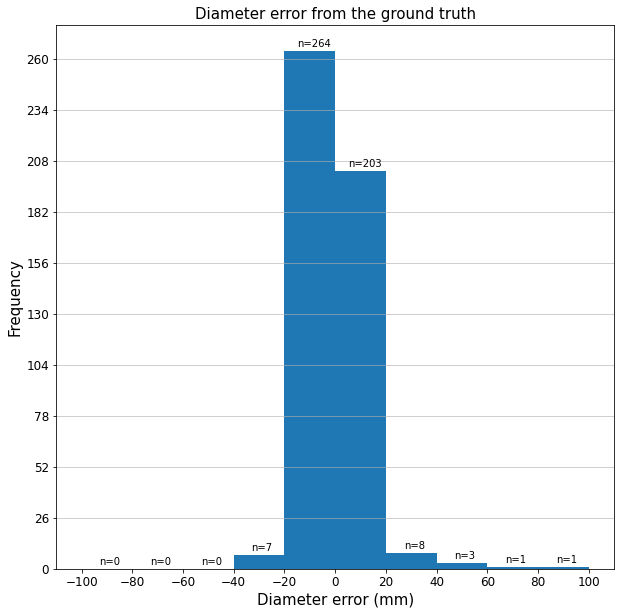

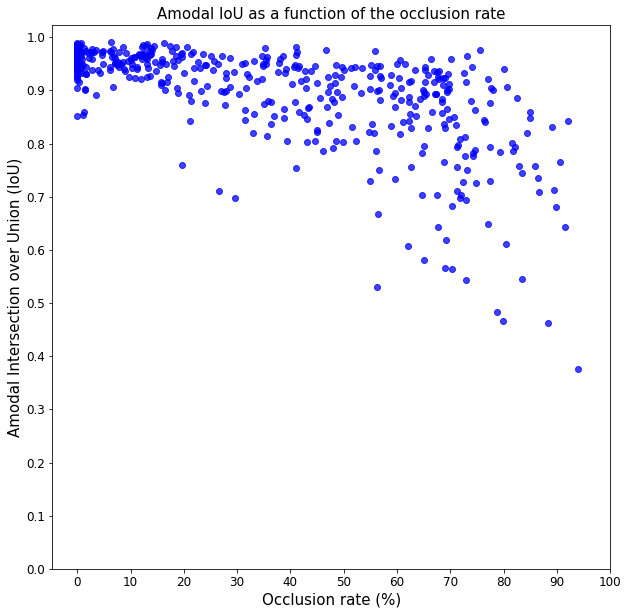

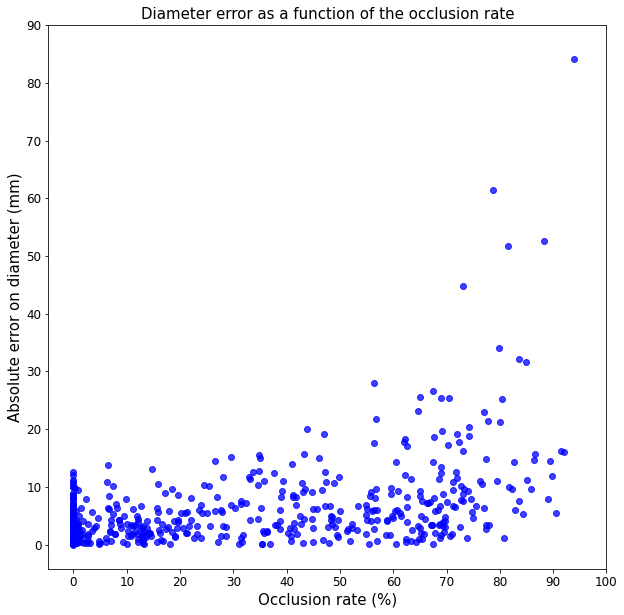

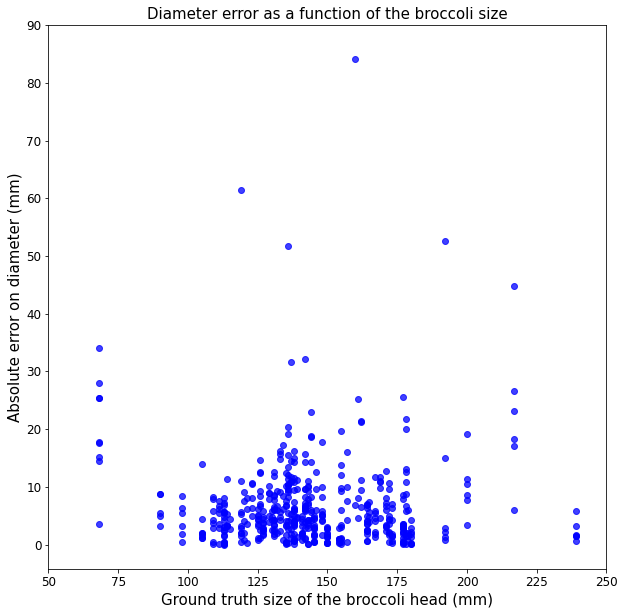

Average image analysis time when sizing 487 broccoli heads: 0.17 s
Highest image analysis time when sizing 487 broccoli heads: 0.24 s


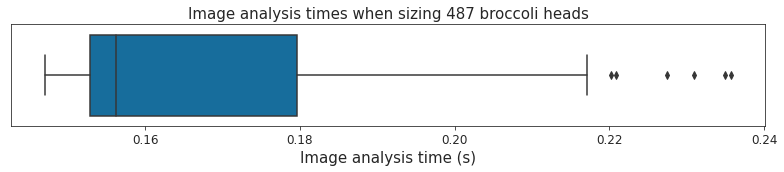

In [11]:
if diffs:
    np.set_printoptions(formatter={'float_kind':'{:f}'.format})

    print("Average error when sizing {0:.0f} broccoli heads: {1:.1f} mm".format(len(dataset_dicts_test), np.average(np.abs(diffs))))
    print("Biggest error when sizing {0:.0f} broccoli heads: {1:.1f} mm".format(len(dataset_dicts_test), np.max(np.abs(diffs))))

    digit_size = 12
    text_size = 15    

    min_bin = statistics.ceil_to_25(-np.max(np.abs(diffs)))
    max_bin = statistics.ceil_to_25(np.max(np.abs(diffs)))
    bin_range = np.abs(max_bin - min_bin)
    
    # Plot the diameter error in a histogram
    statistics.histogram_error(diffs, min_bin, max_bin, bin_range, digit_size, text_size)
    
    
    # Plot the amodal IoU as a function of the occlusion rate (scatter plot)
    statistics.scatterplot_iou(ious, vprs, max_bin, digit_size, text_size)
    
        
    # Plot the diameter error as a function of the occlusion rate (scatter plot)
    statistics.scatterplot_occlusion(diffs, vprs, max_bin, digit_size, text_size)
    

    # Plot the diameter error as a function of the broccoli size (scatter plot)
    statistics.scatterplot_size(diffs, gtsizes, max_bin, digit_size, text_size)
    
    
    print("Average image analysis time when sizing {0:.0f} broccoli heads: {1:.2f} s".format(len(dataset_dicts_test), np.average(inference_times)))
    print("Highest image analysis time when sizing {0:.0f} broccoli heads: {1:.2f} s".format(len(dataset_dicts_test), np.max(inference_times)))
    
    # Plot the inferences times in a boxplot
    statistics.boxplot_time(len(dataset_dicts_test), inference_times, digit_size, text_size)